### This notebook is for getting information about the communities detected by our algorithm. It uses the augmented dataset to get the genre, country and release date information about the movies in communities and prints histograms of the counts in a community. It takes 5 minutes to run since it uses bilouvain implementation to get the communities.

_Again, below cell is Hannah's implementation of the main algorithm and it is included for simplicity when debugging._

In [1]:
"""
This module contains our implementation of the bilouvain algorithm from the following paper:
C. Zhou, L. Feng, and Q. Zhao, “A novel community detection method in bipartite networks,” 
Physica A: Statistical Mechanics and its Applications, vol. 492, pp. 1679–1693, Feb. 2018, 
doi: 10.1016/j.physa.2017.11.089.

Group: Sema Aydin, Hannah Portmann, Diogo Rocha
Implementation: Hannah Portmann
"""

import networkx as nx
import numpy as np

def set_weights_to_one(G):
    """
    Set all weights of the edges in the graph to one in the beginning of the algorithm

    Parameters:
    G: graph

    Returns:
    Nothing, outcome is that all edges of graph G now have an edge weight of 1
    """
    for u, v in G.edges():
        G[u][v]['weight'] = 1


def set_group_order(G):
    """
    Set the order of the groups because the algorithm needs to start with the larger group (here called group red)

    Parameters:
    G: bipartite graph with the attribute node_type with values 'top' and 'bottom' for the two node groups

    Returns:
    groups: dictionary with keys 'red' and 'blue' and the corresponding group of nodes as values
    """
    top_nodes = {n for n, d in G.nodes(data=True) if d["node_type"] == "top"}
    bottom_nodes = set(G) - top_nodes

    # find the longer set of nodes to start with
    # the longer group will be called group red
    if len(top_nodes) > len(bottom_nodes):
        node_group_red = top_nodes
        node_group_blue = bottom_nodes
    else:
        node_group_red = bottom_nodes
        node_group_blue = top_nodes

    groups = {'red': node_group_red, 'blue': node_group_blue}
    return groups


def find_neighbor_communities(G, node, community_assignments):
    """
    Given a node, find the neighboring communities in graph G (depending on the current community_assignments).

    Parameters:
    G: bipartite graph
    node: node that we want to find the neighboring communities of
    community_assignments: dict which contains current communities

    Returns:
    neighboring_communities: set which contains all communities that are directly connected to node
    """
    neighboring_communities = set()

    for community in community_assignments.values():  # check if communities are neighboring to our current node

        # if the node we want to check is in the community already, it must be a neighboring community (except for first iteration, when the node itself is a community - then it is excluded again when checking the length)
        # if the node we want to check is in the community, we need to remove it from that community to check the modularity gain
        if node in community:
            community_copy = set(community)
            community_copy.remove(node)
            if len(community_copy) != 0:  # make sure that it is not an empty community after removing the node
                neighboring_communities.add(tuple(community_copy))  # Add the modified community

        # find the communities that include neighbors of the current node
        else:
            for node_b in community:
                if node_b != node and G.has_edge(node_b, node):
                    neighboring_communities.add(tuple(community))

    return neighboring_communities


def bipartite_modularity_gain(G, node_i, community, group):
    """
    Compute the modularity gain of moving node_i to community. 

    Parameters:
    G: bipartite graph
    node_i: node that we move into community
    community: community that node is moved into
    group: node group of node_i

    Returns:
    delta_q: bipartite modularity gain of moving node_i into community
    """
    comm_other = [node for node in community if
                  node not in group]  # only take into account nodes in community from other node group
    m = sum([data['weight'] for _, _, data in G.edges(data=True)])  # Total sum of edge weights

    edges = G.edges(node_i, data=True)  # find edges incident to node_i
    edges_in_community = [(u, v, data['weight']) for u, v, data in edges if
                          v in comm_other]  # edges and edge weights of edges between node_i and community
    k_i_in = sum(weight for _, _, weight in edges_in_community)  # sum of edge weights in community

    comm_other_edges = [(u, v, data['weight']) for u, v, data in
                        G.edges(comm_other, data=True)]  # edges and edge weights of community nodes in other group
    community_degree = sum(weight for _, _, weight in
                           comm_other_edges)  # sum of degrees considering weight of nodes of other group in community

    # compute modularity gain
    delta_q = k_i_in / m - G.degree(node_i, weight='weight') * community_degree / m ** 2

    return delta_q


def move_node(node, add_community, community_assignments):
    """
    Move a node to a new community and update the community assignments.

    Parameters:
    node: node that should be moved
    add_community: community to which node will be added
    community_assignment: dict containing current communities

    Returns:
    community_assignments: dict which contains the changed communities, where node is now in add_community
    """
    add_community_key, remove_community_key = None, None

    for i, community in community_assignments.items():  # iterate over communities
        if add_community.issubset(community):  # find add community index where node has to be added
            add_community_key = i
        elif node in community:  # find index of community node has to be removed from
            remove_community_key = i

    if add_community_key is not None:
        community_assignments[add_community_key].add(node)  # add node to new community

    if remove_community_key is not None:
        community_assignments[remove_community_key].remove(node)  # remove node from old community
        if len(community_assignments[
                   remove_community_key]) == 0:  # if the community the node was removed from is empty -> delete community
            del community_assignments[remove_community_key]

    return community_assignments


def assignment(G, group, community_assignments):
    """
    Assignment step: assign nodes of current node group to communities.

    Parameters:
    G: bipartite graph
    group: list of nodes in current group, nodes of this group are assigned to communities
    community_assignments: dict which contains the current communities as values

    Returns:
    new_assignments: new dict which contains the new communities
    """
    new_assignments = community_assignments.copy()

    for node in group:  # go over all nodes of the current node group

        # find all neighboring communities
        neighboring_communities = find_neighbor_communities(G, node, new_assignments)

        max_delta_Q = 0

        # calculate modularity gain for all neighboring communities and keep only largest one
        for community in neighboring_communities:
            delta_Q = bipartite_modularity_gain(G, node, community, group)
            if delta_Q > max_delta_Q:
                max_delta_Q = delta_Q
                max_community = set(community)

        # update community of that node
        if max_delta_Q > 0:  # only update if positive modularity gain (if max_delta_Q is still 0, there was no positive modularity gain found)
            new_assignments = move_node(node, max_community, new_assignments)

    # If there were changes in the community assignments, we do the same again with the new community assignments
    if new_assignments != community_assignments:
        assignment(G, group, new_assignments)

    # check if isolated nodes of the group assist, if yes, assign them randomly
    for node in group:
        for community_key, community in new_assignments.items():
            if node in community:
                if len(community) == 1:
                    neighboring_communities = find_neighbor_communities(G, node, new_assignments)
                    random_community = list(neighboring_communities)[0]
                    new_assignments = move_node(node, random_community, new_assignments)

    return new_assignments  # return the communities when there are no changes anymore


def aggregation(group, group_key, community_assignments, G, iteration):
    """
    Aggregation step: aggregate nodes of current node group to hypernodes.

    Parameters:
    group: list of nodes belonging to current group, from which the nodes will be aggregated to hypernodes
    group_key: key of current group (red or blue)
    community_assignments: dict containing current communities
    G: biparite graph
    iteration: integer that indicates current iteration, used to name hypernodes

    Returns:
    H: new hypergraph, where nodes from group which are in the same community are aggregated to hypernodes
    hypernodes: dict, which contains the names of hypernodes as keys and the values are the original nodes that were aggregate to that hypernode
    new_assignments: dict containing the new community assignments, where the nodes from group are replaced by hypernodes
    """
    H = nx.Graph()  # create new hypergraph
    hypernodes = dict()  # create dict for storing hypernodes
    new_assignments = dict()

    # define color of hypernode for hypernode id
    if group_key == 'red':
        x = 'r'
    else:
        x = 'b'

    # first we add all necessary nodes to the graph
    for community_id, nodes in community_assignments.items():
        new_assignments[community_id] = set()

        agg_nodes = []  # find nodes that need to be aggregated to hypernode
        for node in nodes:
            if node in group:  # nodes from current group are aggregated
                agg_nodes.append(node)
            else:  # nodes from other group are not aggregated
                H.add_node(node)  # nodes from other group are not changed
                new_assignments[community_id].add(node)

        if len(agg_nodes) > 0:  # create hypernode if there are nodes to be aggregated
            hypernode_id = f'{x}_{iteration}_{community_id}'  # define name of hypernode
            H.add_node(hypernode_id)  # add hypernode to hypergraph
            hypernodes[hypernode_id] = agg_nodes  # store original nodes of hypernode
            new_assignments[community_id].add(hypernode_id)

    # then we add all the edges
    for hypernode_id, nodes in hypernodes.items():
        for node in nodes:  # find edges of hypernode
            neighbors = G.neighbors(node)
            for neighbor in neighbors:
                if not H.has_edge(hypernode_id, neighbor):  # add edge if it does not exist yet
                    edge_weight = G[node][neighbor].get('weight')
                    H.add_edge(hypernode_id, neighbor,
                               weight=edge_weight)  # add edge with weight it had in Graph before
                else:
                    edge_weight = G[node][neighbor].get('weight')
                    current_weight = H[hypernode_id][neighbor].get(
                        'weight')  # if edge already exists, add 1 to weight for additional edge in original graph
                    new_weight = current_weight + edge_weight
                    H[hypernode_id][neighbor]['weight'] = new_weight  # update weight of edge

    return H, hypernodes, new_assignments


def add_rows_and_columns(matrix, i, j):
    """
    Adds rows i and j and columns i and j of matrix (m x m) together.

    Parameters:
    matrix: original similarity matrix
    i: index of community 1 that should be combined with community 2
    j: index of community 2 that should be combined with community 1

    Returns:
    matrix: new matrix (m-1 x m-1), where rows i and j and columns i and j were added together
    """
    matrix[i] = matrix[i] + matrix[j]
    matrix = np.delete(matrix, j, axis=0)
    matrix[:, i] = matrix[:, i] + matrix[:, j]
    matrix = np.delete(matrix, j, axis=1)
    return matrix


def find_max_indices_and_update(S):
    """
    Finds the index of the maximum value in the matrix S and if the value is positive, combines the rows and columns of those indices.

    Parameters: 
    S: similarity matrix, element S_i_j represents modularity gain of combining communities i and j

    Returns:
    max_indices: the indices of the maximum value in matrix S, if this value is positive, e.g. i and j
    S_new: matrix S, where the rows i and j and columns i and j were added together, representing the combination of those communities
    """
    max_indices = np.unravel_index(np.argmax(S), S.shape)
    if S[max_indices] > 0:
        S_new = add_rows_and_columns(S, max_indices[0], max_indices[1])
        return max_indices, S_new
    else:
        return None, None


def combine_communities(community_order, max_indices, community_assignments):
    """ 
    Now also combining two communities in the community assignments.

    Parameters:
    community_order: ordered list of communities, to identify communities by index
    max_indices: indices of two communities that should be combined
    community_assignments: dict with current communities

    Returns:
    community_assignments: dict with new communities, where the two communities are combined
    community_order: updated ordered list of communities, where the two communities are combined
    """
    comm_1 = community_order[max_indices[0]]
    comm_2 = community_order[max_indices[1]]

    community_assignments[comm_1] = community_assignments[comm_1] | community_assignments[comm_2]
    community_assignments.pop(comm_2)

    community_order.remove(comm_2)

    return community_assignments, community_order


def recursive_update(G, m, community_assignments, S, community_order):
    """
    Updates community_assignments and S recursively, until no combination of communities leads to modularity gain anymore.

    Parameters:
    G: bipartite Graph, currently containg hypernodes created by previous assignment and aggregation steps
    m: number of edges in original graph (corresponds to sum of edge weight in current graph G)
    community_assignments: dict with current communities
    S: similarity matrix, element S_i_j represents modularity gain of combining communities i and j
    community_order: list of sorted community_ids

    Returns:
    community_assignments: final communities of hypernodes, where no combination of communities would increase modularity anymore
    """
    max_indices, S_new = find_max_indices_and_update(S)

    if max_indices is not None and S_new is not None:
        community_assignments_new, community_order_new = combine_communities(community_order, max_indices,
                                                                             community_assignments)
        return recursive_update(G, m, community_assignments_new, S_new, community_order_new)

    else:
        return community_assignments


def clustering(G, m, community_assignments):
    """
    Clustering algorithm implementation in matrix form. Communities are combined, if their combination increases bipartite modularity. 
    
    Parameters:
    G: bipartite Graph, currently containg hypernodes created by previous assignment and aggregation steps
    m: number of edges in original graph (corresponds to sum of edge weight in current graph G)
    community_assignments: dict with current communities

    Returns:
    Result of recursive_update function
    The following new parameters are given to this function:
    S: similarity matrix, element S_i_j represents modularity gain of combining communities i and j
    community_order: list of sorted community_ids
    """
    community_order = sorted([community_id for community_id in community_assignments.keys()])
    sorted_nodes_blue = [node for community_id in community_order for node in community_assignments[community_id] if
                         node.startswith('b')]
    sorted_nodes_red = [node for community_id in community_order for node in community_assignments[community_id] if
                        node.startswith('r')]
    sorted_nodes = sorted_nodes_blue + sorted_nodes_red
    
    comm_len = len(community_order)

    adj_matrix = nx.adjacency_matrix(G, nodelist=sorted_nodes)
    adj_matrix = adj_matrix.toarray()

    R = adj_matrix[comm_len:, :comm_len]
    e = np.ones((comm_len, 1))
    d = np.dot(R, e)
    g = np.dot(R.T, e)

    S = 1 / m * (R + R.T - (np.dot(d, g.T) + np.dot(g, d.T)) / m)
    np.fill_diagonal(S, -np.inf)

    return recursive_update(G, m, community_assignments, S, community_order)

def unpack_hypernodes(node, all_hypernodes):
    """
    Unpack hypernode recursively to find original nodes which were aggregated to hypernode.

    Parameters:
    node: hypernode, which has to be unpacked
    all_hypernodes: dict which contains for each hypernode a list of nodes, which were aggregated to that hypernode

    Returns: 
    List of original nodes contained in a hypernode
    """
    if node in all_hypernodes:
        return [unpack_hypernodes(sub_node, all_hypernodes) for sub_node in all_hypernodes[node]]
    else:
        return [node]


def flatten(nested_list):
    """
    Flatten nested list which was created by unpack_hypernodes function.

    Parameters:
    nested_list: nested list that originates when hypernodes are unpacked

    Returns: 
    1 dimensional list containing nodes from nested_list
    """
    if len(nested_list) == 0:
        return nested_list
    if isinstance(nested_list[0], list):
        return flatten(nested_list[0]) + flatten(nested_list[1:])
    return nested_list[:1] + flatten(nested_list[1:])


def final_communities(community_assignments, all_hypernodes):
    """
    Find communities of original nodes by unpacking all hypernodes.

    Parameters:
    community_assignments: dict with current community_assignments, containing hypernodes
    all_hypernodes: dict containing information about which nodes were aggregated to form a hypernode

    Returns:
    final_community_ass: final assignments of communities, containing only the original nodes of the graph given to the algorithm
    """
    final_community_ass = dict()

    # go through communities
    for community_id, nodes in community_assignments.items():
        final_community_ass[community_id] = []

        # go through nodes in communities and unpack them
        for node in nodes:
            final_community_ass[community_id].extend(unpack_hypernodes(node, all_hypernodes))

        # flatten found final communities
        final_community_ass[community_id] = flatten(final_community_ass[community_id])

    return final_community_ass


def bilouvain(Graph):
    """
    Main function to find communities in a bipartite graph according to bilouvain algorithm by Zhou et al. (2018).
    
    Parameters:
    Graph: a bipartite graph with node attributes "node_type" set to the values "top" and "bottom"

    Returns: 
    final_community_assignments: dictionary with the final communities as values, the key does not have any meaning anymore
    """

    G = Graph.copy()
    m = G.number_of_edges()
    set_weights_to_one(G)  # set all weights in graph to one to begin with (make sure they have attribute weight)
    groups = set_group_order(G)  # set which group of nodes comes first (longer one)

    # initialize communities
    community_assignments = {i: {n} for i, n in enumerate(G)}

    all_hypernodes = dict()  # initialize dict where the contents of all hypernodes will be stored

    # create variables for stop condition
    no_change_red = False
    no_change_blue = False

    i = 0  # count iterations

    while not no_change_red or not no_change_blue:  # if there are no more changes in both community assignment steps, the loop stops

        i += 1  # increase iteration by one (for naming hypernodes)
#         print(f'iteration: {i}')

        # assignment on red nodes
        community_assignments_before = community_assignments.copy()
        community_assignments = assignment(G, groups['red'], community_assignments)
        if community_assignments == community_assignments_before:
            no_change_red = True

        # aggregation on red nodes
        G, hypernodes, community_assignments = aggregation(groups['red'], 'red', community_assignments, G, iteration=i)
        groups['red'] = list(hypernodes.keys())
        all_hypernodes.update(hypernodes)

        # assignment on blue nodes
        community_assignments_before = community_assignments.copy()
        community_assignments = assignment(G, groups['blue'], community_assignments)
        if community_assignments == community_assignments_before:
            no_change_blue = True

        # aggregation on blue nodes
        G, hypernodes, community_assignments = aggregation(groups['blue'], 'blue', community_assignments, G,
                                                           iteration=i)
        groups['blue'] = list(hypernodes.keys())
        all_hypernodes.update(hypernodes)

    # clustering step on balanced communities
    community_assignments = clustering(G, m, community_assignments)

    # find final communities with original nodes
    final_community_assignments = final_communities(community_assignments, all_hypernodes)

    return final_community_assignments

**Cells below are Sema's code for analysis and evaluation.**

In [2]:
# getting the community labels for the sample we have chosen using our bilouvain implementation
import networkx as nx
import pandas as pd
import time

data = pd.read_csv('clean_letterboxd.csv')
letterboxd = data.drop('rating', axis=1)
lboxd = letterboxd.sample(n=9000, random_state=42)

# create graph
G_sample = nx.Graph()
G_sample.add_nodes_from(lboxd['user'].unique(), bipartite=0)
G_sample.add_nodes_from(lboxd['title'].unique(), bipartite=1)
G_sample.add_edges_from(lboxd[['user', 'title']].values)

# Get the sets of nodes
users_sample = {n for n, d in G_sample.nodes(data=True) if d['bipartite'] == 0}
movies_sample = {n for n, d in G_sample.nodes(data=True) if d['bipartite'] == 1}

# Print the number of nodes in the sets
print(f"number of users in the sample set: {len(users_sample)}")
print(f"number of movies in the sample set: {len(movies_sample)}")

node_types = {node:'top' if node in users_sample else 'bottom' for node in G_sample.nodes}

nx.set_node_attributes(G_sample, node_types, name="node_type")

start_time = time.time()

communities_sample = bilouvain(G_sample)

end_time = time.time()
ex_time = end_time - start_time
print(f"execution time: {ex_time}")

number of users in the sample set: 545
number of movies in the sample set: 6477
execution time: 172.95235681533813


In [3]:
aug_data = pd.read_csv('augm_movies400.csv')
aug_lbxd = aug_data.drop(['rating','minute'], axis=1)
aug_lbxd

,user,title,movie_id,date,mean_rating,genre,country
0,144,Glass Onion: A Knives Out Mystery,34732,NaN,NaN,NaN,NaN
1,144,Nope,59848,2022.0,3.74,"['Horror', 'Mystery', 'Science Fiction']","['USA', 'Japan']"
2,144,Everything Everywhere All at Once,29301,2022.0,4.32,"['Science Fiction', 'Action', 'Adventure']",['USA']
3,144,The Batman,81918,2022.0,3.99,"['Thriller', 'Mystery', 'Crime']",['USA']
4,144,Spider-Man: No Way Home,76567,2021.0,3.85,"['Science Fiction', 'Action', 'Adventure']",['USA']
...,...,...,...,...,...,...,...
69256,290,Alien,6403,1979.0,4.28,"['Horror', 'Science Fiction']","['USA', 'UK']"
69257,290,Star Wars,77108,1977.0,4.18,"['Adventure', 'Action', 'Science Fiction']",['USA']
69258,290,Taxi Driver,80046,1976.0,4.18,"['Crime', 'Drama']",['USA']
69259,290,Jaws,43827,1975.0,3.98,"['Adventure', 'Thriller', 'Horror']",['USA']


In [4]:
# Utility function to convert strings to lists
import ast

def convert_to_list(s):
    # If the value is a nan, just return a nan
    if pd.isna(s):
        return np.nan

    # Try to parse the value
    try:
        # Only parse the value if it looks like a str list
        if isinstance(s, str) and s.startswith('[') and s.endswith(']'):
            return ast.literal_eval(s)
        # In case it's something else, check for single quotation mark or double quotation mark
        elif isinstance(s, str) and (s == "'" or s == '"'):
            return []
        # In case it's something else, just return it
        else:
            return s
    # This catches cases where the list contains a nan -> [nan]
    except (ValueError, SyntaxError):
        return s


In [5]:
# Cast genre and country columns from augm_movies from strings (stored that way) back to lists
aug_lbxd.dropna(inplace=True)
aug_lbxd['genre'] = aug_lbxd['genre'].apply(convert_to_list)
aug_lbxd['country'] = aug_lbxd['country'].apply(convert_to_list)

In [6]:
# Function to process communities and extract movie information
def process_communities(communities, graph, dataset):
    # Dictionary to store counts of genres, years, and countries for each community
    community_info = {}
    
    # Iterate over communities
    for label, nodes in communities.items():
        movie_nodes = movies_sample
        movie_data = dataset[dataset['title'].isin(movie_nodes)]
        
        # Create an empty dictionary to store genre counts
        genre_counts = {}
        
        # Iterate over movies in the current community
        for genres in movie_data['genre']:
            for genre in genres:
                genre_counts[genre] = genre_counts.get(genre, 0) + 1
        
        # Convert genre counts dictionary to a pandas Series
        genre_counts_series = pd.Series(genre_counts)
        
        # Count years for movies in the current community
        year_counts = movie_data['date'].value_counts()
        
        # Count countries for movies in the current community
        country_counts = movie_data['country'].explode().value_counts()
        
        # Store counts in the community_info dictionary
        community_info[label] = {
            'genre_counts': genre_counts_series,
            'year_counts': year_counts,
            'country_counts': country_counts
        }
    
    return community_info
# Process communities to extract movie information
community_info = process_communities(communities_sample, G_sample, aug_lbxd)

# Print community information
for label, info in community_info.items():
    print(f"Community {label}:")
    print("Genre Counts:")
    print(info['genre_counts'])
    print("Year Counts:")
    print(info['year_counts'])
    print("Country Counts:")
    print(info['country_counts'])

Community 0:
Genre Counts:
Horror              8898
Mystery             6861
Science Fiction    20375
Action             19518
Adventure          23210
Thriller           12536
Crime              10237
Romance             5597
Comedy             15357
Drama              22491
War                  850
Animation           7794
Family              9048
Fantasy             9631
Music                936
Western              413
dtype: int64
Year Counts:
2019.0    6335
2017.0    5716
2016.0    4257
2014.0    3557
2015.0    3012
2004.0    2987
2010.0    2652
2018.0    2620
2001.0    2561
2012.0    2551
2013.0    2135
2007.0    1710
2022.0    1384
1999.0    1370
1994.0    1335
2021.0    1290
2008.0     917
1995.0     913
1980.0     892
2003.0     890
2011.0     866
2002.0     866
1977.0     862
1993.0     859
1985.0     856
2005.0     834
1992.0     830
1982.0     806
1996.0     478
2000.0     469
1978.0     457
1990.0     448
1998.0     443
1991.0     438
1975.0     437
1976.0     434
2009.0 

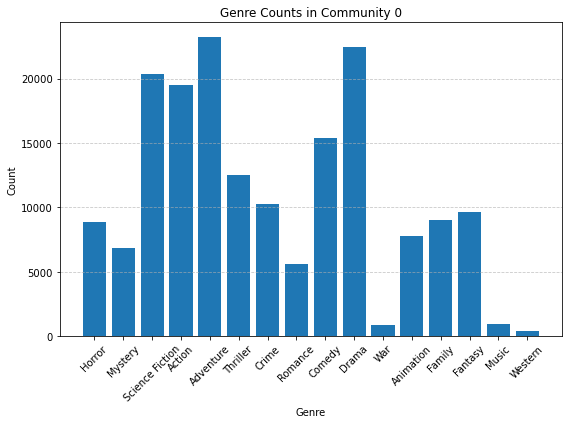

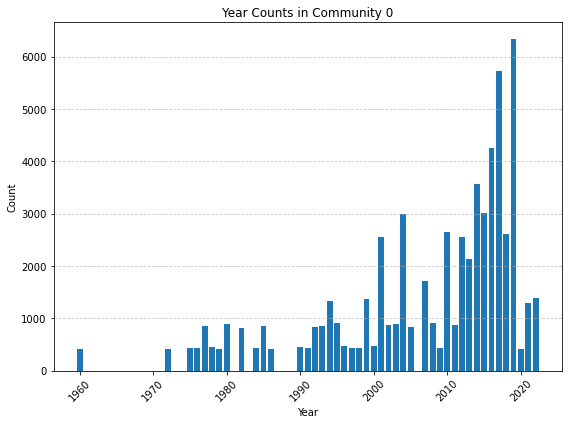

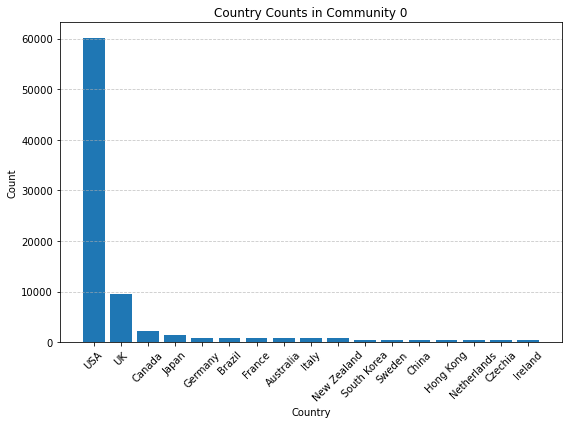

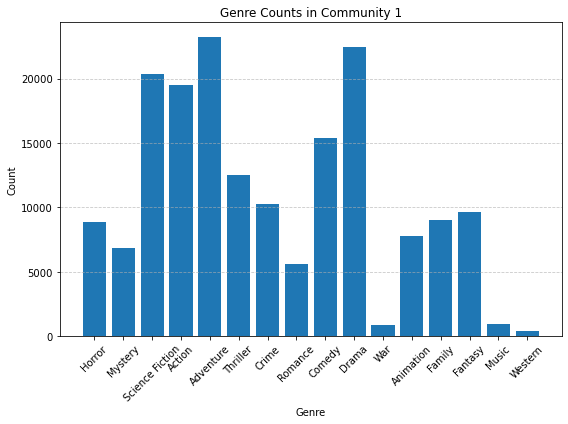

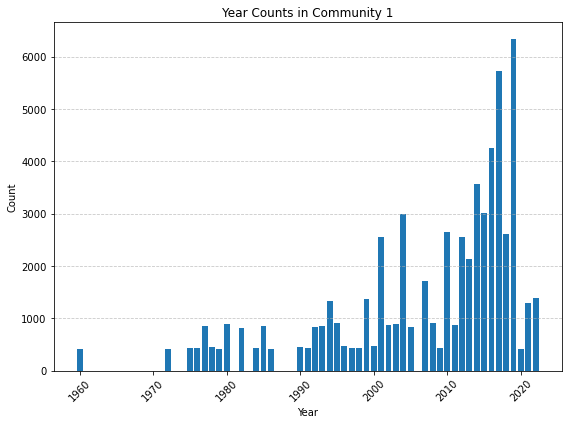

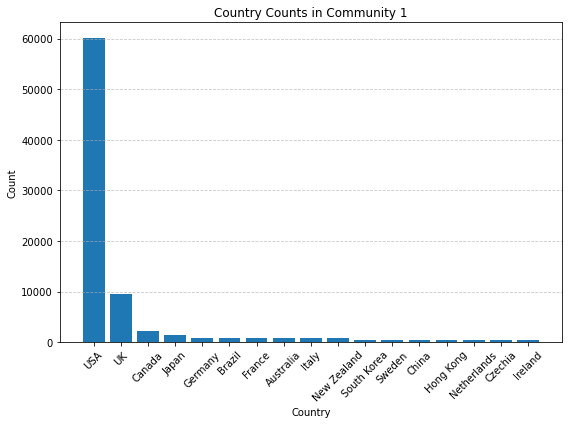

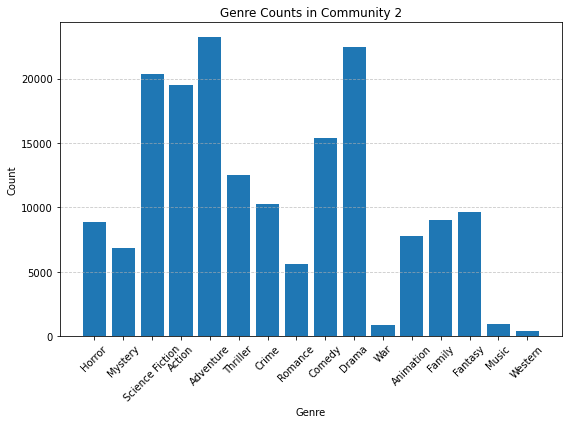

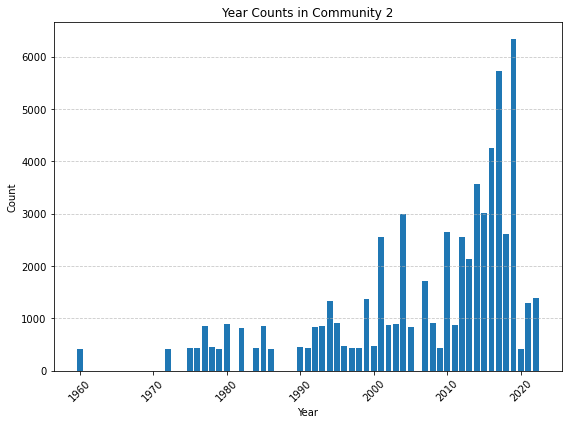

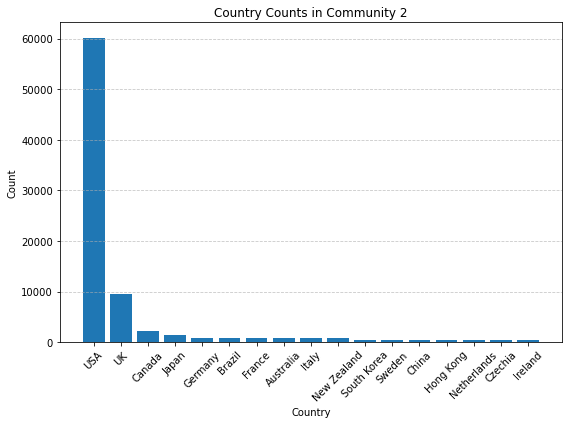

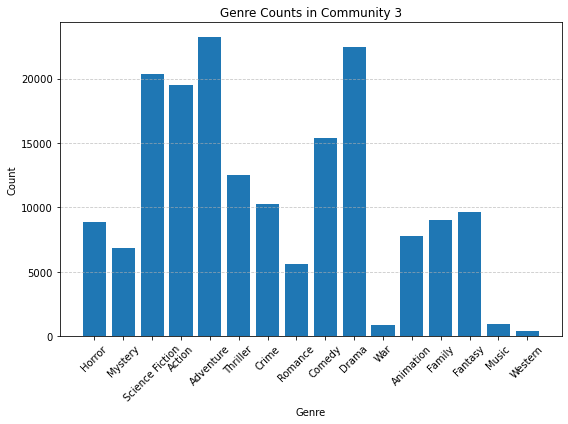

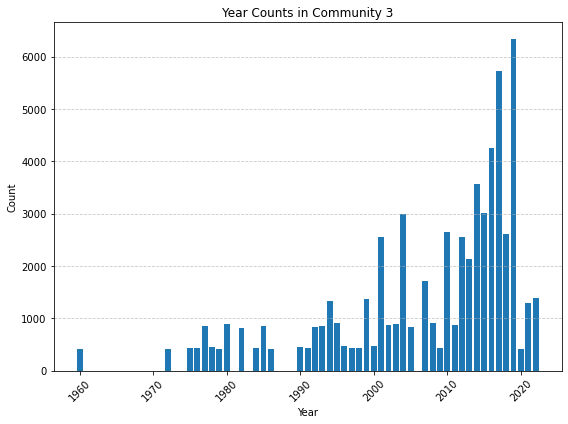

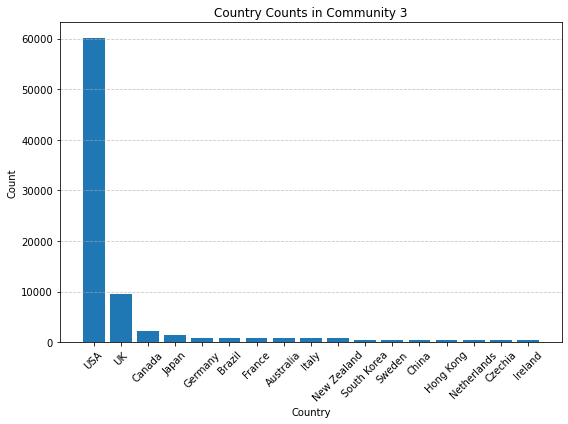

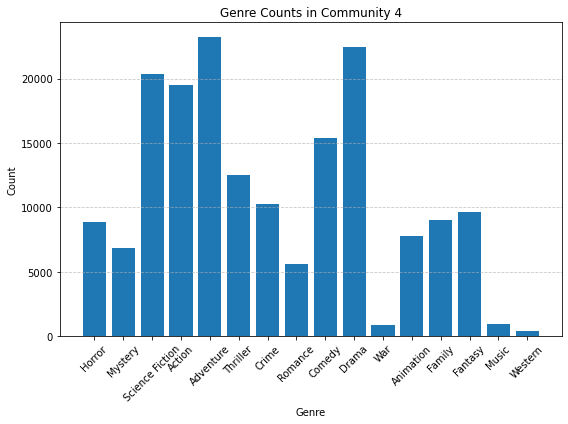

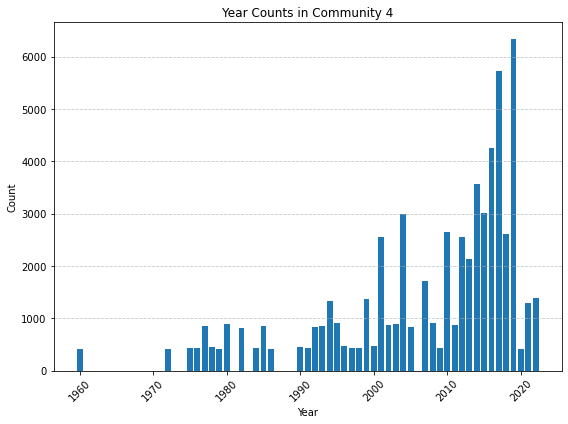

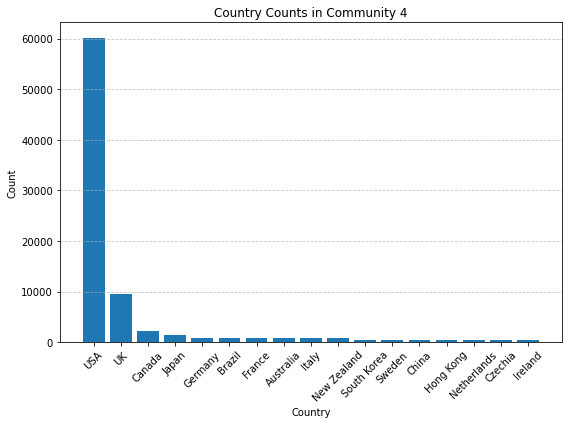

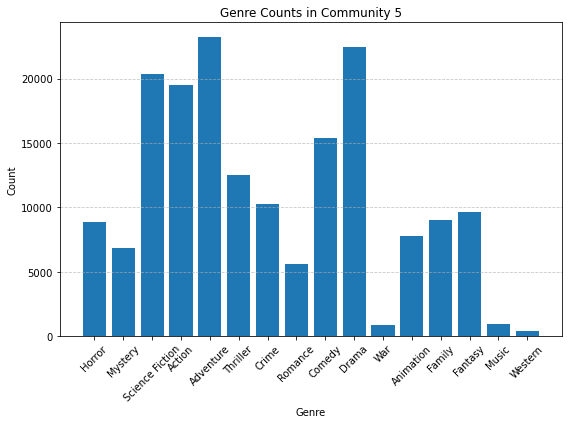

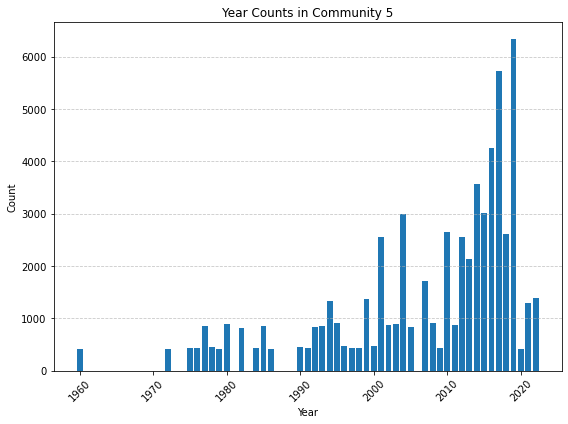

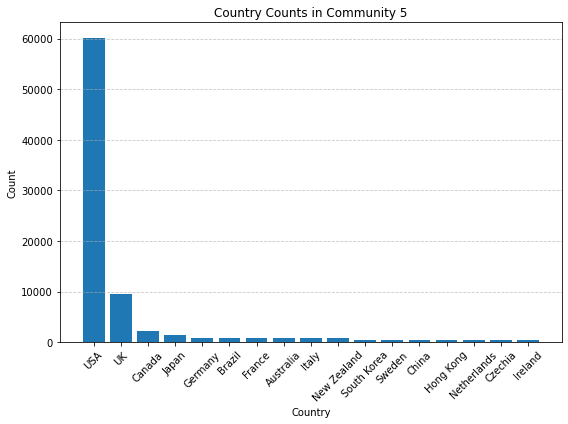

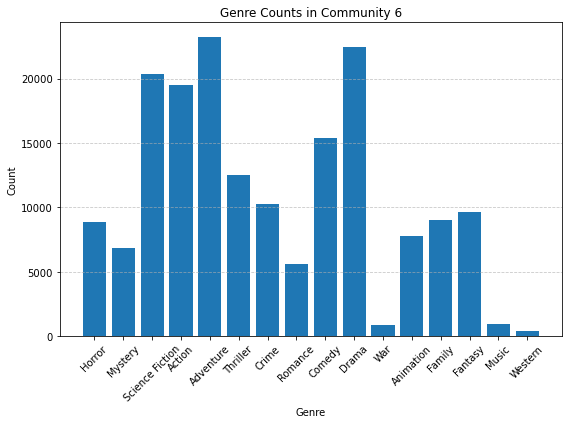

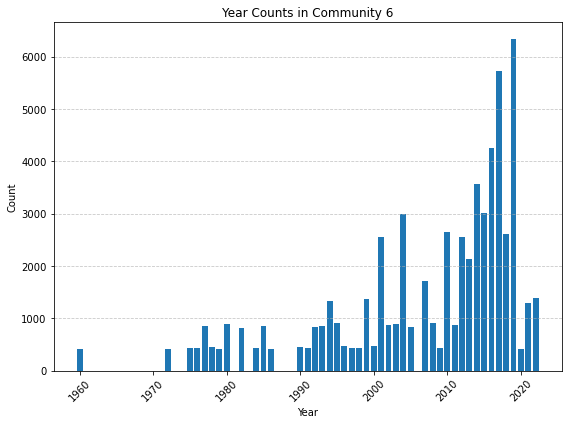

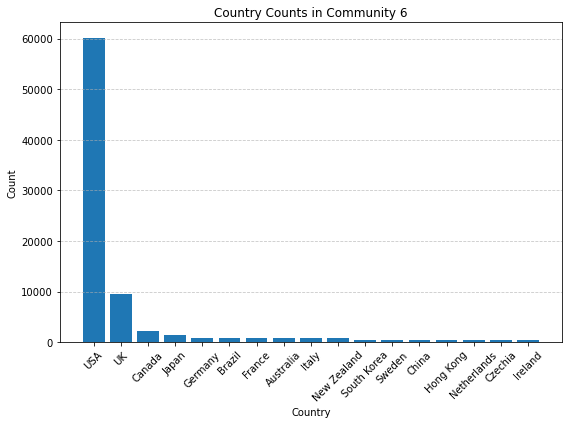

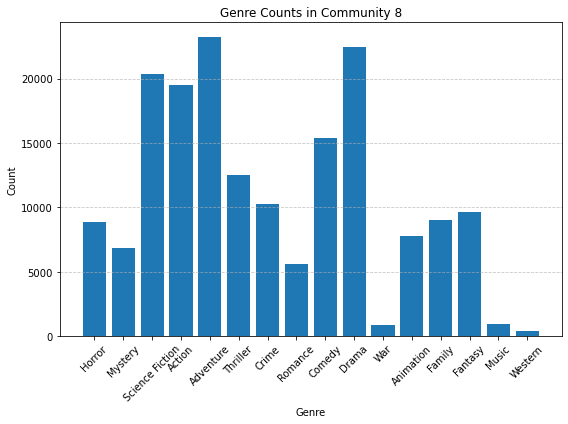

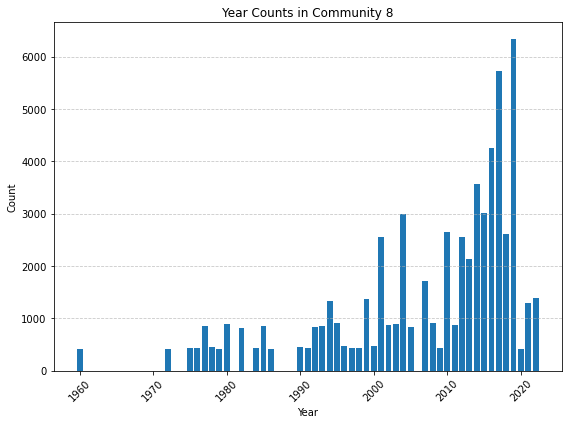

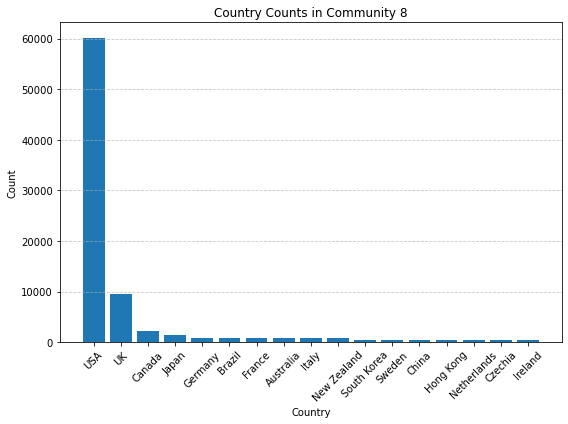

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# Function to plot histograms
def plot_histogram(data, title, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    plt.bar(data.index, data.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot histograms for the 8 largest communities, based on the information length
for label, info in sorted(community_info.items(), key=lambda x: len(x[1]), reverse=True)[:8]:
    
    genre_counts = info['genre_counts']
    plot_histogram(genre_counts, f'Genre Counts in Community {label}', 'Genre', 'Count')
    
    year_counts = info['year_counts']
    plot_histogram(year_counts, f'Year Counts in Community {label}', 'Year', 'Count')
    
    country_counts = info['country_counts']
    plot_histogram(country_counts, f'Country Counts in Community {label}', 'Country', 'Count')
